In [1]:
import librosa
import IPython
import music21 as mu
from midi2audio import FluidSynth
import pandas as pd
import numpy as np
import sympy as sp
from IPython.display import HTML, IFrame
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from IPython.display import Image

# update music21 environment so it can find MuseScore
mu.environment.set('musescoreDirectPNGPath', '/usr/bin/musescore')

# utility function for sound playback
def create_sound_file_from_midi(m21_data, file_name):
    m21_data.write('midi', fp = file_name + ".mid")
    fs = FluidSynth()
    fs.midi_to_audio('./' + file_name + ".mid", file_name + '.mp3')
    return(IPython.display.Audio("./" + file_name + ".mp3"))

In [437]:
# get hold of some data
mahler_ex = mu.converter.parse("./MidiAndMusicXMLFiles/MahlerSymphonies/symphony1/MusicXML/3rd-movement-Feierlich-und-gemessen-ohne-zu-schleppend.mxl")

In [438]:
# examine the list of parts
partList = mahler_ex.getElementsByClass(mu.stream.Part)

In [439]:
# Create a list of parts
pList = []
for i in range(0, len(partList)):
    pList.append(partList[i])

In [525]:
# Render a data frame 
# turn into function - createScoreEventData()
events = []

currentNumerator = None
currentDenominator = None
currentInstrument = None
currentInstrumentName = None
currentPartName = None


for eachPart in pList:
    

    for el in eachPart.flatten():

        eventDictionary = {}
        eventDictionary['offset'] = el.offset
        eventDictionary['quarterLengthDuration'] = el.duration.quarterLength
        eventDictionary['measureNumber'] = el.measureNumber
        eventDictionary['currentNumerator'] = currentNumerator
        eventDictionary['currentDenominator'] = currentDenominator
        eventDictionary['instrument'] = currentInstrumentName
        eventDictionary['part'] = currentPartName


        currentType = str(type(el))

        if currentType == "<class 'music21.meter.base.TimeSignature'>":

            currentNumerator = el.numerator
            currentDenominator = el.denominator

        if "instrument" in currentType:

            currentInstrumentName = el.instrumentName
            currentPartName = el.partName

        if currentType == "<class 'music21.note.Rest'>":
            #print("REST")
            eventDictionary['nameWithOctave'] = "NA"
            eventDictionary['midiNumber'] = -1
            eventDictionary['fullName'] = "Rest"
            eventDictionary['name'] = "NA"
            eventDictionary['octave'] = "NA"
            events.append(eventDictionary)
            
            
        if currentType == "<class 'music21.note.Note'>":
            eventDictionary['nameWithOctave'] = el.nameWithOctave
            eventDictionary['midiNumber'] = el.pitches[0].midi
            eventDictionary['fullName'] = el.pitches[0].fullName
            eventDictionary['name'] = el.pitches[0].name
            eventDictionary['octave'] = el.pitches[0].octave
            events.append(eventDictionary)

        elif currentType == "<class 'music21.chord.Chord'>":
            #print("HERE", el.measureNumber)

            for eachNote in el:
              #  print(eachNote.pitches[0].midi)
                tempEventDictionary = eventDictionary.copy()
                
                tempEventDictionary['nameWithOctave'] = eachNote.nameWithOctave
                tempEventDictionary['midiNumber'] = eachNote.pitches[0].midi
                tempEventDictionary['fullName'] = eachNote.pitches[0].fullName
                tempEventDictionary['name'] = eachNote.pitches[0].name
                tempEventDictionary['octave'] = eachNote.pitches[0].octave
                events.append(tempEventDictionary)
                #print(eventDictionary)
            

In [526]:
#mahler_ex.measures(23, 28).show('text')

In [527]:
#events

In [528]:
# examine different types of objects
scoreEventData = pd.DataFrame(events)
scoreEventData['offsetAsFloat'] = scoreEventData['offset'].astype(float)
scoreEventData['quarterLengthDurationAsFloat'] = scoreEventData.quarterLengthDuration.astype(float)
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(scoreEventData.part)))
scoreEventData['partColor'] = colors.tolist()

In [541]:
#scoreEventData[(scoreEventData.measureNumber >= 24) & (scoreEventData.measureNumber <= 24) &   (scoreEventData.midiNumber != -1) ]

In [530]:
scoreEventData.describe()

,measureNumber,currentNumerator,currentDenominator,midiNumber,offsetAsFloat,quarterLengthDurationAsFloat
count,11674.000000,11674.0,11674.0,11674.000000,11674.000000,11674.000000
mean,86.675690,4.0,4.0,39.460168,343.858690,1.654378
std,46.025844,0.0,0.0,31.026147,184.136900,1.459956
min,1.000000,4.0,4.0,-1.000000,0.000000,0.035417
25%,47.000000,4.0,4.0,-1.000000,184.500000,0.500000
50%,88.000000,4.0,4.0,50.000000,349.000000,1.000000
75%,129.000000,4.0,4.0,65.000000,514.068750,4.000000
max,169.000000,4.0,4.0,93.000000,674.091667,4.000000


In [531]:
# next to create a visualisation
# note midi number is y coord
# OffsetAsFloat is x coord
# quarterlength duration is width

In [532]:
def create_axis_for_sdr(ax, x_limit, y_limit, population, label, create_label = True):
    
    if create_label:

        ax.set_xlabel(label)
        
    ax.set_xticks(range(int(x_limit)))
    ax.set_yticks(range(int(y_limit)))
    [ax.xaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(x_limit))]
    [ax.yaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(y_limit))]
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(color='k', linestyle='-', linewidth=.5)
    ax.tick_params(axis = "both", which = "both", bottom = False, top = False)

    
    return(ax)


In [533]:
scoreEventData.part.value_counts()


Harp, Harfe                              940
Bassoon, Fagotte I II III                775
Violins, Violine II                      741
Harp, Contrabasse                        729
Violoncellos, Violoncelle                713
Flute, Fl�ten I II III IV                682
Oboe, Oboen I II III IV                  614
Violins, Violine I                       613
Violoncello, Viola                       579
Horn in F, H�rner in F I II              551
Horn in F, H�rner in F III IV            440
Timpani, Pauken                          431
B♭ Clarinet, Klarinette in Eb            417
B♭ Trumpet, Trompetten in F I II         416
B♭ Clarinet, Klarinetten in C I II       407
Horn in F, H�rner in F V VI              406
B♭ Clarinet, Klarinetten in B I II       381
Timpani, Grosse Trommel                  271
B♭ Bass Clarinet, Bassklarinette in B    254
English Horn, English Horn               254
Drumset, T�rkishe Becken                 231
Trombone, Pausonen I II                  221
Bass Tromb

In [545]:
def convertDataForScoreVisualisation(scoreDataAsDF, startMeasure, endMeasure):

    df1 = scoreDataAsDF[(scoreDataAsDF.measureNumber >= startMeasure) & (scoreDataAsDF.measureNumber <= endMeasure) & (scoreDataAsDF.midiNumber != -1)]
    
    
    
    offsetForStart = min(df1.offsetAsFloat)
    minMidiNumber = min(df1.midiNumber)
    maxMidiNumber = max(df1.midiNumber)
   
    df2 = df1[["offsetAsFloat", "midiNumber", "quarterLengthDurationAsFloat", "partColor"]].copy()
    
    
    
    df2['new_col'] = list(zip(df2["offsetAsFloat"]-offsetForStart + 5, df2["midiNumber"] - minMidiNumber + 5))
    df2['height'] = 1
    df2['color'] = "green"
    df2['col2'] = list(zip(df2["new_col"], df2["quarterLengthDurationAsFloat"], df2["height"], df2["partColor"]))
    
    coords = df2.col2.values
    

    
    return([coords, minMidiNumber, maxMidiNumber])

In [546]:
 #df2 = scoreEventData[(scoreEventData.measureNumber >= 100) & (scoreEventData.measureNumber <= 105) & (scoreEventData.instrument == 'Strings')].reset_index()

In [536]:
def createStreamFromDF(dfData):
    pass

In [537]:
def createScoreFormatting(ax1, yOffset):
    
    # formatting data
    text_kwargs = dict( fontsize=32, color='white')
    
    keyColorCoords = [((5, 1), 80, 1), ((5, 3), 80, 1), ((5, 6), 80, 1), ((5, 8), 80, 1), ((5, 10), 80, 1), 
                 ((5, 13), 80, 1),((5, 15), 80, 1),((5, 18), 80, 1),((5, 20), 80, 1),((5, 22), 80, 1),
                 ((5, 25), 80, 1), ((5, 27), 80, 1), ((5, 30), 80, 1), ((5, 32), 80, 1), ((5, 34), 80, 1),
                 ((5, 37), 80, 1), ((5, 39), 80, 1), ((5, 42), 80, 1), ((5, 44), 80, 1), ((5, 46), 80, 1),
                 ((5, 49), 80, 1), ((5, 51), 80, 1), ((5, 54), 80, 1), ((5, 56), 80, 1), ((5, 58), 80, 1),
                 ((5, 61), 80, 1), ((5, 63), 80, 1), ((5, 66), 80, 1), ((5, 68), 80, 1), ((5, 70), 80, 1),
                 ((5, 73), 80, 1), ((5, 75), 80, 1), ((5, 78), 80, 1), ((5, 80), 80, 1), ((5, 82), 80, 1),
                 ((5, 85), 80, 1), ((5, 87), 80, 1), ((5, 90), 80, 1), ((5, 92), 80, 1), ((5, 94), 80, 1),
                 ((5, 97), 80, 1), ((5, 99), 80, 1), ((5, 102), 80, 1), ((5, 104), 80, 1), ((5, 106), 80, 1),
                 ((5, 109), 80, 1), ((5, 111), 80, 1), ((5, 114), 80, 1), ((5, 116), 80, 1), ((5, 118), 80, 1)]

    octaveZone1Coords = [((0, 0), 5, 12),((0, 24), 5, 12), ((0, 48), 5, 12), ((0, 72), 5, 12),  ((0, 96), 5, 12),  ((0, 120), 5, 12)]
    octaveZone2Coords = [((0, 12), 5, 12),((0, 36), 5, 12), ((0, 60), 5, 12), ((0, 84), 5, 12),  ((0, 108), 5, 12),  ((0, 132), 5, 12)]
    
    octaveNumbers = [(2, 6, '1'),(2, 18, '2'),(2, 30, '3'), (2, 42, '4'),(2, 54, '5'), (2, 66, '6'),(2, 78, '7'),(2, 90, '8'), (2, 102, '9')]
    

    
    # Draw black and white keys
    [ax1.add_patch(Rectangle((keyColorCoords[i][0][0],keyColorCoords[i][0][1] - yOffset), keyColorCoords[i][1], keyColorCoords[i][2], color="#EBECF0", zorder = -10)) for i in range(len(keyColorCoords))]
    
    # Draw octave zones
    [ax1.add_patch(Rectangle((octaveZone1Coords[j][0][0], octaveZone1Coords[j][0][1] - yOffset), octaveZone1Coords[j][1], octaveZone1Coords[j][2], color="black", zorder = 2)) for j in range(len(octaveZone1Coords))]
    [ax1.add_patch(Rectangle((octaveZone2Coords[j][0][0], octaveZone2Coords[j][0][1] - yOffset), octaveZone2Coords[j][1], octaveZone2Coords[j][2], color="gray", zorder = 2)) for j in range(len(octaveZone2Coords))]
    
    # Draw octave numbers 
    [ax1.text(2, octaveNumbers[k][1] - yOffset, octaveNumbers[k][2], **text_kwargs) for k in range(len(octaveNumbers))]
    
    
    ax1.add_patch(Rectangle((74, 0), 10, 80, color = "black"))
    
    
 
    return(ax1)

In [539]:
coords1 = convertDataForScoreVisualisation(scoreEventData, 24, 24)

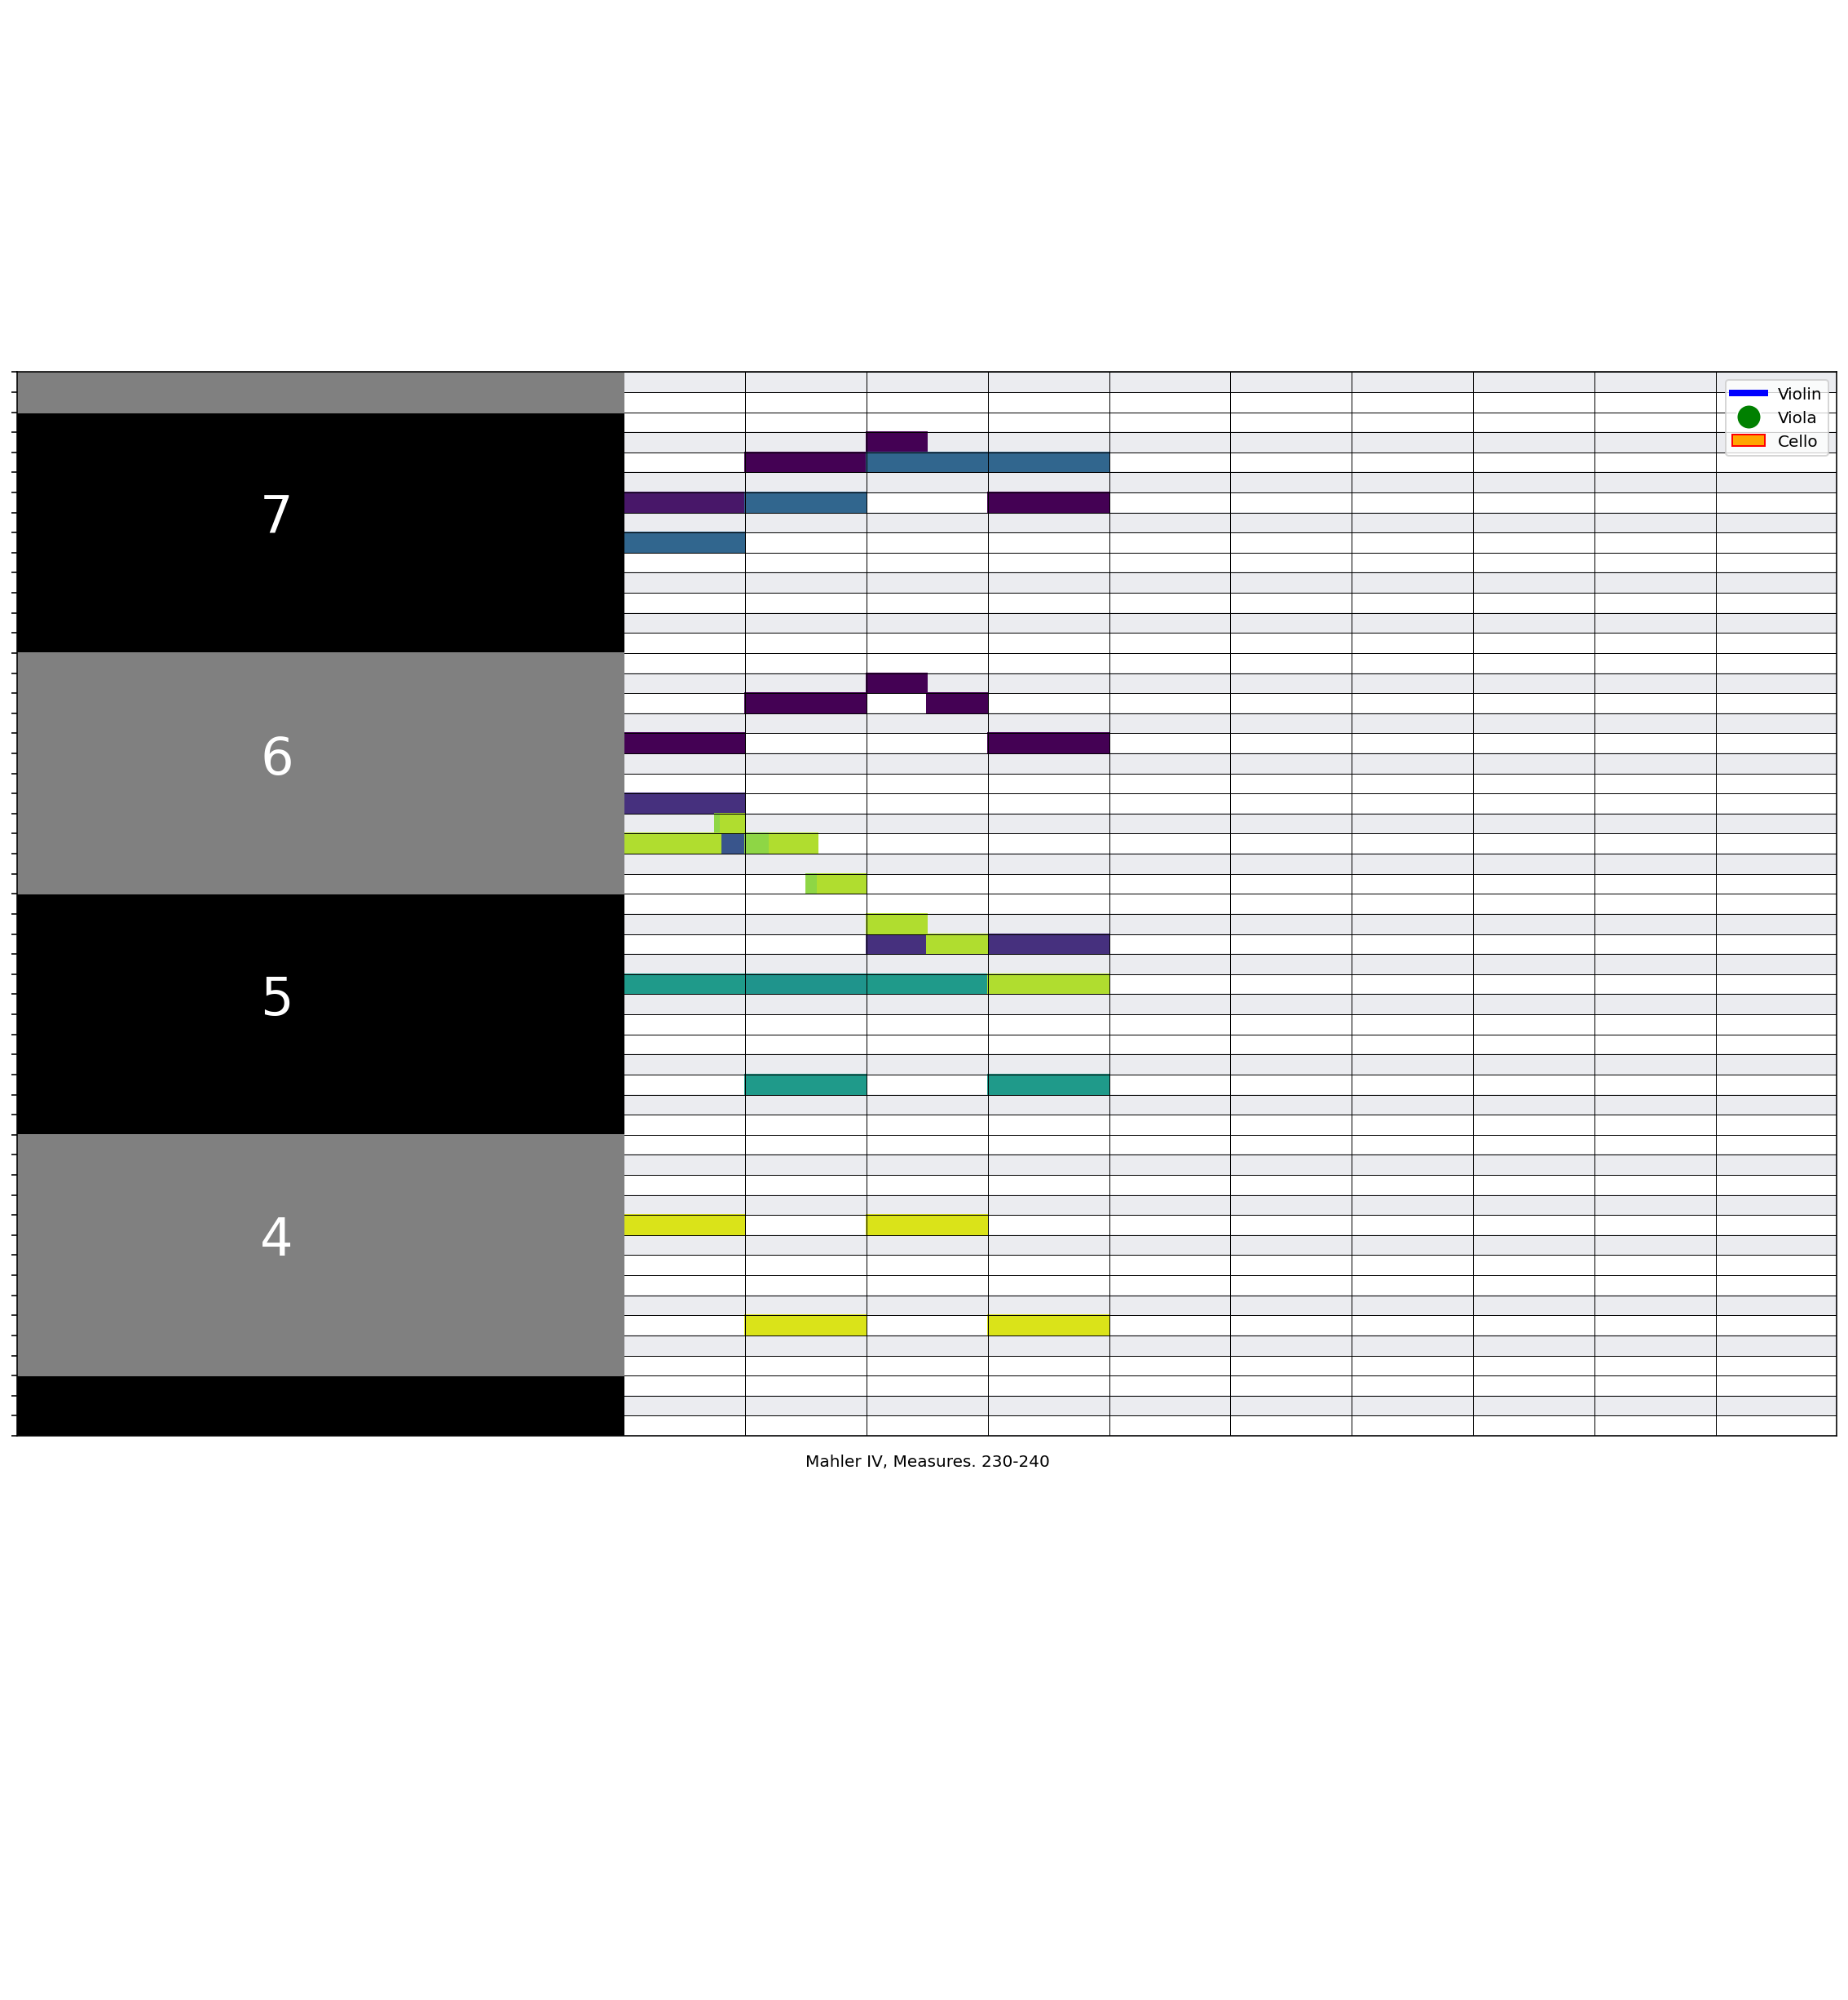

In [544]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='b', lw=4, label='Violin'),
                   Line2D([0], [0], marker='o', color='w', label='Viola',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r',
                         label='Cello')]


fig, (ax1) = plt.subplots(1, 1, figsize=(20, 12))

ax1 = create_axis_for_sdr(ax1, 16, (coords1[2] - coords1[1]) + 10, 4, "Mahler IV, Measures. 230-240")
t = [ax1.add_patch(Rectangle(coords1[0][i][0], coords1[0][i][1], coords1[0][i][2], color = coords1[0][i][3])) for i in range(len(coords1[0]))]
ax1.legend(handles=legend_elements, loc='upper right')

f1 = createScoreFormatting(ax1, coords1[1])






In [495]:
mahler_ex.measures(24, 24).show('text')

{0.0} <music21.stream.Part Flute, Fl�ten I II III IV>
    {0.0} <music21.instrument.Flute 'P1: Flute, Fl�ten I II III IV: Flute'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.KeySignature of 1 flat>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.stream.Measure 24 offset=0.0>
        {0.0} <music21.layout.PageLayout>
        {0.0} <music21.layout.SystemLayout>
        {0.0} <music21.chord.Chord D4 D5>
        {1.0} <music21.chord.Chord E4 E5>
        {2.0} <music21.chord.Chord F4 F5>
        {2.5} <music21.chord.Chord E4 E5>
        {3.0} <music21.chord.Chord D4 D5>
{0.0} <music21.stream.Part Oboe, Oboen I II III IV>
    {0.0} <music21.instrument.Oboe 'P2: Oboe, Oboen I II III IV: Oboe'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.KeySignature of 1 flat>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.stream.Measure 24 offset=0.0>
        {0.0} <music21.layout.PageLayout>
        {0.0} <music21.layout.StaffLayout distance 65, s